In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import os

import sys
import time
from scipy.stats import norm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from helper import df_to_latex, fig_path, set_figsize, tab_path

# Import code from src
sys.path.insert(0, '../src/')
import vmc 

In [ ]:
pd.set_option('display.max_columns', 50)
#pd.options.display.float_format= '{e:.5f}'.format 
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

fontsize = "large"

params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          #"font.size": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
         }
          
    
plt.rcParams.update(params)
plt.rc('text', usetex=True)

In [2]:
def exact_energy(N, dim, omega):
    return (omega * dim * N) / 2

def safe_initial_positions_no_interactions(wavefunction, alpha, N, dim, seed=None):
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))

    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14:
        positions *= 0.5
        wf2 = wavefunction.pdf(positions, alpha)

    return positions

def safe_initial_positions_w_interactions(wavefunction, alpha, N, dim, seed=None): 
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))
    
    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14: 
        positions *= 2.0
        wf2 = wavefunction.pdf(positions, alpha)
        
    return positions

def interact_initial_positions(wf, alpha, N, dim, a=0.00433):

    rng = np.random.default_rng()

    def corr_factor(r1, r2):
        rij = np.linalg.norm(r1 - r2)
        if rij <= a:
            return 0.
        else:
            return 1 - (a / rij)

    scale = 2.
    r = np.random.randn(N, dim) * scale
    #r = rng.random(size=(N, dim))

    rerun = True
    while rerun:
        rerun = False
        for i in range(N):
            for j in range(i + 1, N):
                corr = corr_factor(r[i, :], r[j, :])
                if corr == 0.:
                    print("corr=0 encountered")
                    rerun = True
                    r[i, :] = np.random.randn() * scale
                    r[j, :] = np.random.randn() * scale
        scale *= 1.5

    return r, scale

def get_mean_w_standard_error_grid_search(data, alphas): 
    data_dict = {"alpha": alphas, "energy": [], "standard_error":[],"standard_error_of_the_mean": []}
    for i, alpha in enumerate(alphas): 
        energies_alpha = data["energy"][data["alpha"]==alpha]
        standard_errors_alpha = data["standard_error"][data["alpha"]==alpha]
        mean_energy_alpha = np.mean(energies_alpha)
        standard_error = np.mean(standard_errors_alpha)
        standard_error_of_the_mean = np.std(standard_errors_alpha)/np.sqrt(len(standard_errors_alpha))
        data_dict["energy"].append(mean_energy_alpha)
        data_dict["standard_error"].append(standard_error)
        data_dict["standard_error_of_the_mean"].append(standard_error_of_the_mean)
        
    dataframe = pd.DataFrame(data=data_dict)
    return dataframe


In [13]:
N = 50
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_10 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler_NI = vmc.samplers.MetropolisHastings(wf)

# Config
nsamples = int(2**16)
alpha_step = 0.1
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)
results_NI_N10 = []

initial_positions = safe_initial_positions_no_interactions(wf,
                                                           alpha,
                                                           N,
                                                           dim)
start = time.time()
for i, alpha in enumerate(alphas):
    result = sampler_NI.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=2,
                            dt=0.01,
                            seed=None,
                            warm=True,
                            warmup_iter=20000,
                            tune=True,
                            tune_iter=30000,
                            tune_interval=1000,
                            tol_tune=1e-7,
                            optimize=False
                           )
    results_NI_N10.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

KeyboardInterrupt: 

In [10]:
df_NI_N50 = pd.concat(results_NI_N10, ignore_index=True)
df_means_NI_N50 = get_mean_w_standard_error_grid_search(df_NI_N50, alphas)
df_means_NI_N50

,alpha,energy,standard_error,standard_error_of_the_mean
0,0.1,219.957716,1.582343,0.032993
1,0.2,121.219848,0.663477,0.092274
2,0.3,90.798645,0.348994,0.002297
3,0.4,79.524518,0.128191,0.002123
4,0.5,75.000000,0.000000,0.000000
5,0.6,74.333491,0.124402,0.008510
6,0.7,75.641000,0.219606,0.013053
7,0.8,77.875039,0.313120,0.003840
8,0.9,82.027571,0.419299,0.030239
9,1.0,86.363536,0.515295,0.005102


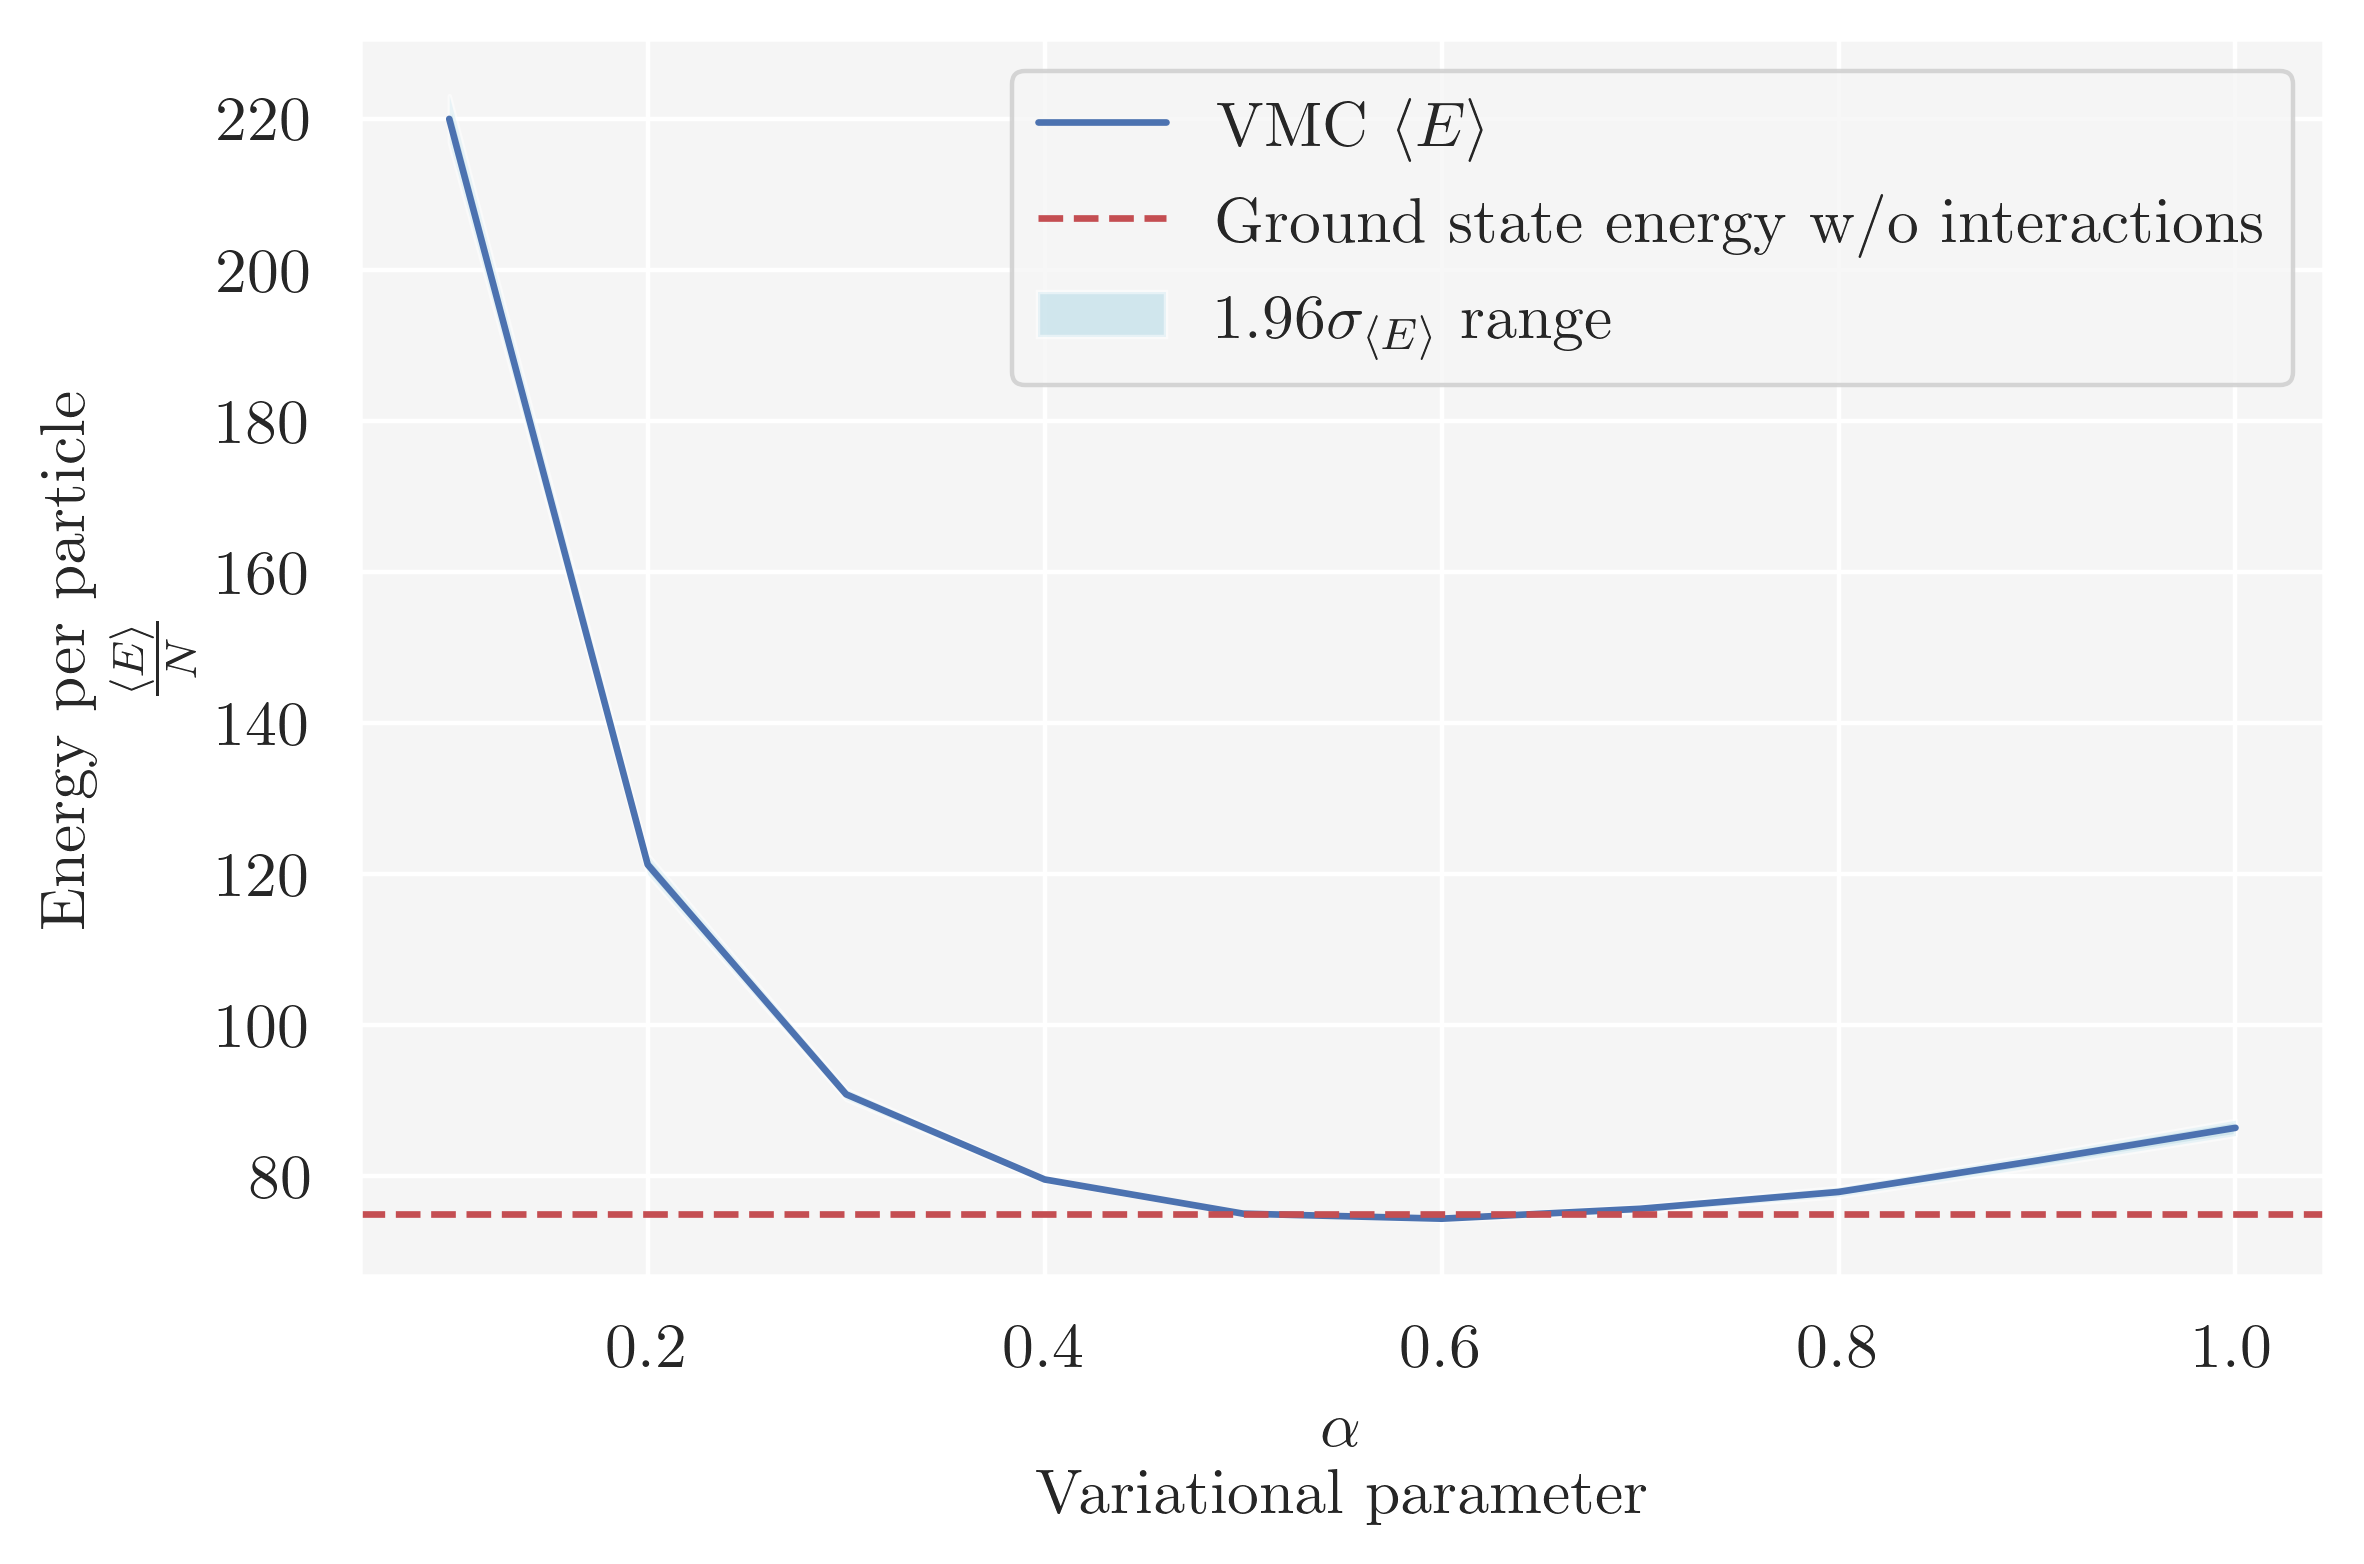

In [12]:
lower_bound = df_means_NI_N50["energy"] - 1.96*df_means_NI_N50["standard_error"]
upper_bound = df_means_NI_N50["energy"] + 1.96*df_means_NI_N50["standard_error"]
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df_means_NI_N50, x="alpha", y="energy", ax=ax, label=r'VMC $\langle E\rangle$')
ax.fill_between(df_means_NI_N50["alpha"], lower_bound, upper_bound, facecolor='lightblue', alpha=0.5,
                label=r'$1.96\sigma_{\langle E\rangle}$ range')
ax.axhline(75, ls='--', color='r', label='Ground state energy w/o interactions')
tex_xlabel = '\n'.join((r'$\alpha$',
                      'Variational parameter'))
tex_ylabel = '\n'.join(('Energy per particle',
                        r'$\frac{\langle E\rangle}{N}$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

#fig.savefig(fig_path("gr.pdf"), bbox_inches='tight')

## Elliptical potential optimal alpha

In [3]:
N = 10
dim = 3
omega = 1.0
initial_alpha = 0.5
wf = vmc.AEHOIB(N, dim, omega)
sampler = vmc.Metropolis(wf)
nsamples = int(2**16)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler.sample(nsamples, 
                        initial_positions, 
                        initial_alpha, 
                        nchains= 2, 
                        scale=1.0, 
                        warm=True,
                        warmup_iter = 20000,
                        tune=True, 
                        tune_iter=30000, 
                        tune_interval=1000,
                        optimize=True,
                        max_iter=200000,
                        batch_size=2000,
                        gradient_method='adam',
                        eta=0.01,
                        tol_optim=1e-7,
                        )
end = time.time()
print("Sampler elapsed time:", end - start)
print(results)

Warm done
Warm done
Tune done
Tune done
Warm after tune done
Warm after tune done
Optimize done, final alpha: 0.4985852401032462
Retune done
Optimize done, final alpha: 0.4971012417715694
Retune done
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Sampler elapsed time: 174.76005291938782
   nparticles  dim     alpha     energy  standard_error  accept_rate
0          10    3  0.498585  24.443847        0.001658     0.246918
1          10    3  0.497101  24.459769        0.002015     0.330109
Warm done
Warm done
Tune done
Tune done
Warm after tune done
Warm after tune done


Process ForkPoolWorker-2:
Traceback (most recent call last):
Process ForkPoolWorker-1:
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jeb/.local/lib/python3.8/site-packages/pathos/helpers/mp_helper.py", line 15, in <l

   nparticles  dim     alpha     energy  standard_error  accept_rate
0          10    3  0.497319  24.405923        0.001727      0.06308
1          10    3  0.490474  24.434427        0.005165      0.17424


In [5]:
N = 50
dim = 3
omega = 1.0
initial_alpha = 0.5
wf = vmc.AEHOIB(N, dim, omega)
sampler = vmc.Metropolis(wf)
nsamples = int(2**16)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results_N50 = sampler.sample(nsamples, 
                        initial_positions, 
                        initial_alpha, 
                        nchains= 1, 
                        scale=1.0, 
                        warm=True,
                        warmup_iter = 20000,
                        tune=True, 
                        tune_iter=30000, 
                        tune_interval=1000,
                        optimize=True,
                        max_iter=200000,
                        batch_size=2000,
                        gradient_method='adam',
                        eta=0.01,
                        tol_optim=1e-7,
                        )
end = time.time()
print("Sampler elapsed time:", end - start)
print(results_N50)

Warm done
Tune done
Warm after tune done
Optimize done, final alpha: 0.49626115169617185
Retune done
Rewarming done
Sampling energy
Sampler elapsed time: 337.8215672969818
   nparticles  dim     alpha      energy  standard_error  accept_rate
0          50    3  0.496261  128.416873        0.031099     0.318069


In [ ]:
N = 100
dim = 3
omega = 1.0
initial_alpha = 0.2
wf = vmc.AEHOIB(N, dim, omega)
sampler = vmc.Metropolis(wf)
nsamples = int(2**16)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results_N100 = sampler.sample(nsamples, 
                        initial_positions, 
                        initial_alpha, 
                        nchains= 2, 
                        scale=1.0, 
                        warm=True,
                        warmup_iter = 20000,
                        tune=True, 
                        tune_iter=30000, 
                        tune_interval=1000,
                        optimize=True,
                        max_iter=200000,
                        batch_size=2000,
                        gradient_method='adam',
                        eta=0.01,
                        tol_optim=1e-7,
                        )
end = time.time()
print("Sampler elapsed time:", end - start)
print(results_N100)